In [5]:
get_ipython().run_line_magic('matplotlib', 'inline')
import os, sys

# sys.path.append("~/X/PythonForDataScience/air_traffic_project/submissions/first_real_submission/")

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problem import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
import geopy.distance
from sklearn.metrics import mean_squared_error
from model_selection_python import *
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

from estimator import _merge_external_data

pd.set_option('display.max_columns', None)

In [6]:
X_train, y_train = get_train_data('..')
X_test, y_test = get_test_data('..')

X_train_merged = _merge_external_data(X_train)
X_test_merged = _merge_external_data(X_test)

In [7]:
X_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8902 entries, 0 to 8901
Data columns (total 78 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   WeeksToDeparture                8902 non-null   float64
 1   std_wtd                         8902 non-null   float64
 2   Days_to_departure               8902 non-null   float64
 3   year_booked                     8902 non-null   int64  
 4   month_booked                    8902 non-null   int64  
 5   day_booked                      8902 non-null   int64  
 6   weekday_booked                  8902 non-null   int64  
 7   week_booked                     8902 non-null   int64  
 8   n_days_booked                   8902 non-null   int64  
 9   oil_stock_price                 8902 non-null   float64
 10  oil_stock_volume                8902 non-null   float64
 11  AAL_stock_price                 8902 non-null   float64
 12  AAL_stock_volume                89

In [10]:
X_train_data = X_train_merged[['WeeksToDeparture', 'oil_stock_price', 'oil_stock_volume',
                    'AAL_stock_price', 'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume',
                    'latitude_deg_dep', 'longitude_deg_dep', 'pop2010_dep', 
                    'latitude_deg_arr', 'longitude_deg_arr', 'pop2010_arr', 'distance',
                    'LoadFactorDomestic_arr', 'PassengersDomestic_arr', 'holidays_dep', 'holidays_arr', 'closest_holidays_dep',
                    'closest_holidays_arr', 'GDP_per_cap_dep', 'GDP_per_cap_arr', 'UnemploymentRate_dep', 'UnemploymentRate_arr', 'month_departure', 
                    'day_departure', 'weekday_departure', 'week_departure', 'n_days_departure']]


# forest = RandomForestRegressor(min_samples_split=0.01, max_features=0.5, oob_score=True, verbose=0)
# score = cross_val_score(forest, X_forest, y_train, cv=5)

In [11]:
grid_params = {
    'min_samples_split': [0.01],
    'max_features': [0.5]
}

gs = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=grid_params,
                  n_jobs=-1,
                  cv=5,
                  verbose=0)

gs.fit(X_train_data, y_train)        
print(gs.best_score_)                                                             

0.7508452815789679


In [13]:
# Prediction performance on test set is not as good as on train set
X_test_data = X_test_merged[['WeeksToDeparture', 'oil_stock_price', 'oil_stock_volume',
                    'AAL_stock_price', 'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume',
                    'latitude_deg_dep', 'longitude_deg_dep', 'pop2010_dep', 
                    'latitude_deg_arr', 'longitude_deg_arr', 'pop2010_arr', 'distance',
                    'LoadFactorDomestic_arr', 'PassengersDomestic_arr', 'holidays_dep', 
                    'holidays_arr', 'closest_holidays_dep',
                    'closest_holidays_arr', 'GDP_per_cap_dep', 'GDP_per_cap_arr', 'UnemploymentRate_dep', 'UnemploymentRate_arr', 'month_departure', 
                    'day_departure', 'weekday_departure', 'week_departure', 'n_days_departure']]

score_test = gs.score(X_test_data, y_test)
print(score_test)

0.7245975369007247


In [14]:
print("Testing RMSE: ", mean_squared_error(y_test, gs.predict(X_test_data), squared=False))

Testing RMSE:  0.5327774698178931


### Feature Importance

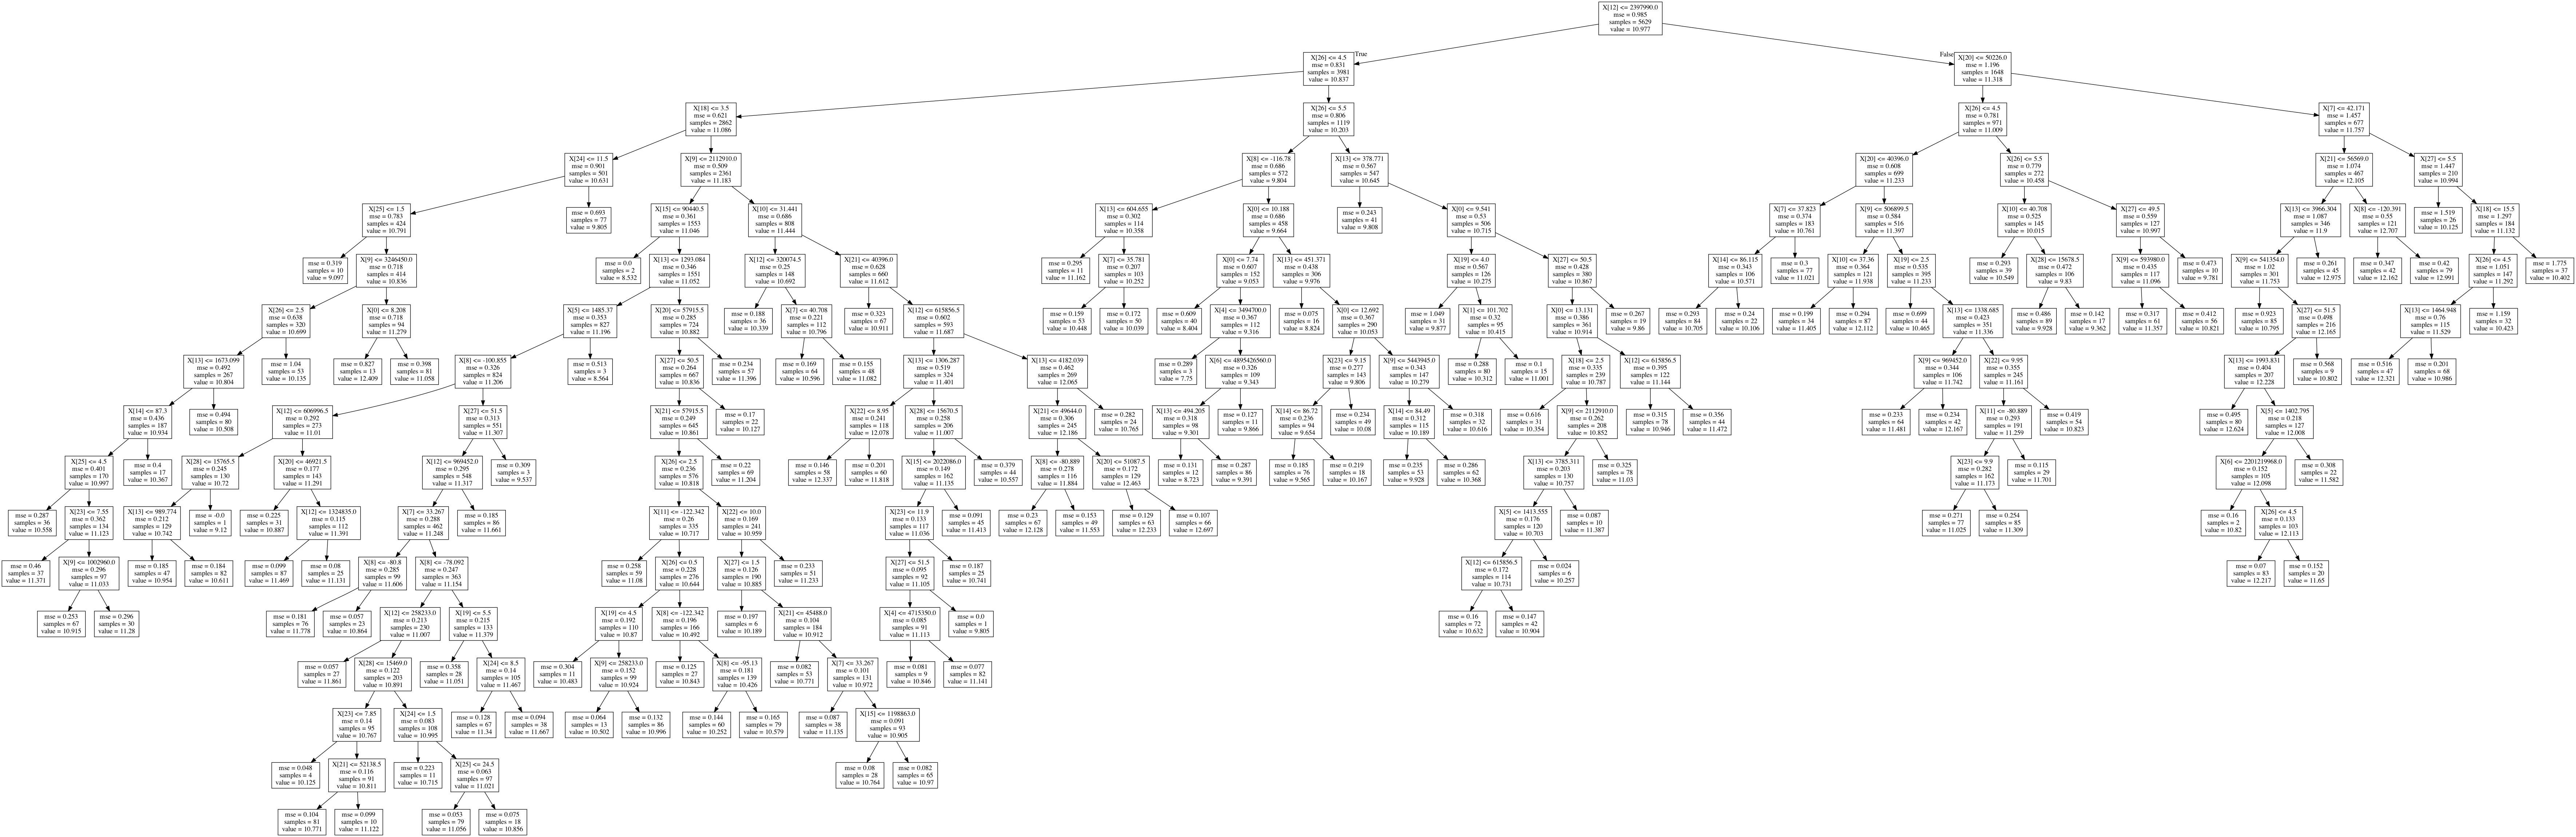

In [15]:
forest_estimator = gs.best_estimator_
pipeline = make_pipeline(forest_estimator)
pipeline.fit(X_train_data, y_train).score(X_test_data, y_test)

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
dot_data = StringIO()
export_graphviz(pipeline[0].estimators_[0], out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

# viz = dtreeviz(forest_estimator.estimators_[0], X_train_data, y_train, feature_names=X_train_data.columns, target_name="Target")
# viz

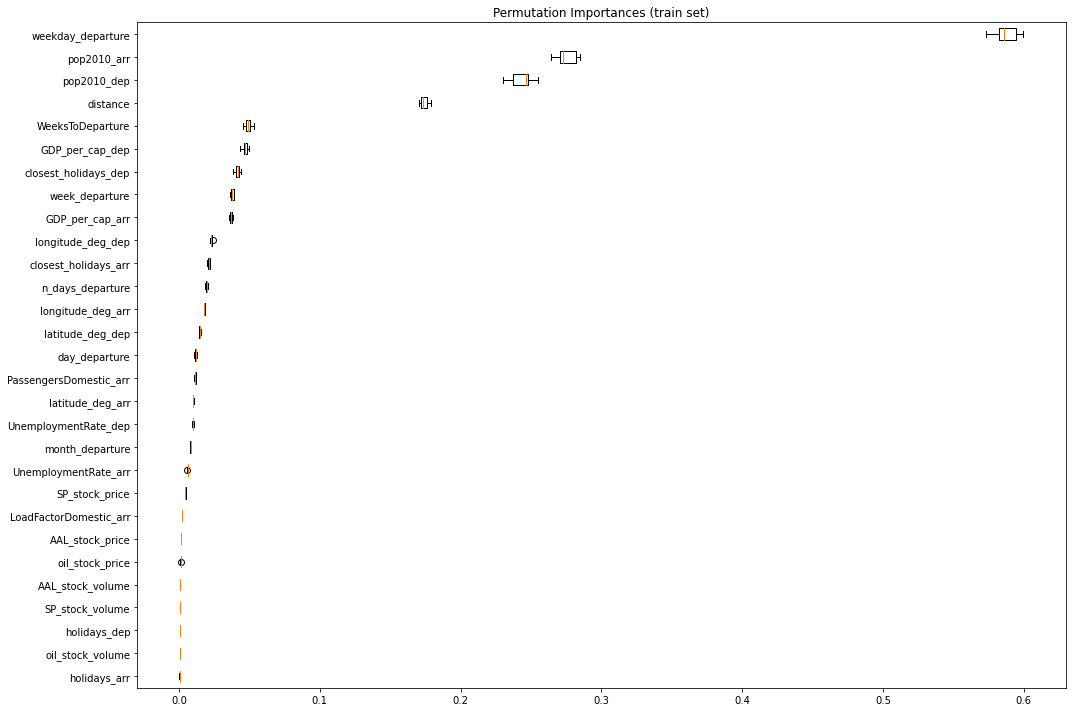

In [16]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    pipeline, X_train_data, y_train, n_repeats=10
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_data.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    pipeline, X_test_data, y_test, n_repeats=10
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_test_data.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
# plt.figure(figsize=(30, 30))
# sns.heatmap(abs(Xy_train.corr()), cmap='BrBG', annot=True, vmin=-1, vmax=1)

In [ ]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
# #     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

In [ ]:
# plt.figure(figsize=(8, 15))
# heatmap = sns.heatmap(Xy_train.corr()[['Passengers']].sort_values(by='Passengers', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

# grid_params = {
#     'n_neighbors': range(1, 200),
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan'],
# }

# gs = GridSearchCV(
#     KNeighborsRegressor(),
#     grid_params,
#     verbose=1,
#     cv=3,
#     n_jobs=-1
# )

# gs_results = gs.fit(X_train, y_train)

In [ ]:
# print(gs_results.best_score_)
# print(gs_results.best_estimator_)
# print(gs_results.best_params_)

In [ ]:
# X_train, y_train = problem.get_train_data('..')

In [ ]:

# grid_params = {
#     'randomforestregressor__n_estimators': [50, 100],
#     'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
#     'randomforestregressor__max_depth': [4, 6, 8],
#     'randomforestregressor__criterion': ['mse']
# }

# # pipe = make_pipeline(StandardScaler(with_mean=False), RandomForestRegressor())

# gs = GridSearchCV(
#     pipe,
#     grid_params,
#     verbose=1,
#     cv=3,
#     n_jobs=-1
# )

# gs_results = gs.fit(X_train, y_train)

In [ ]:
# print(gs_results.best_score_)
# print(gs_results.best_estimator_)
# print(gs_results.best_params_)

## Feature Importance

In [ ]:
# from sklearn.inspection import permutation_importance

# feature_importances = permutation_importance(
#     pipe, X_train, y_train, n_repeats=10
# )
# sorted_idx = feature_importances.importances_mean.argsort()

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.boxplot(feature_importances.importances[sorted_idx].T,
#            vert=False, labels=X_train.columns[sorted_idx])
# ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
# plt.show()

In [ ]:
# feature_importances = permutation_importance(
#     pipe, X_test, y_test, n_repeats=10
# )
# sorted_idx = feature_importances.importances_mean.argsort()

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.boxplot(feature_importances.importances[sorted_idx].T,
#            vert=False, labels=X_test.columns[sorted_idx])
# ax.set_title("Permutation Importances (test set)")
# fig.tight_layout()
# plt.show()

## Predictor Selection

In [ ]:
# X_train = sm.add_constant(X_train)
# print(X_train.info())
# print("X as array:", np.asarray(X_train))
# print("y as array:", np.asarray(y_train))
# model_both = forwardSelection(X_train.astype(float), y_train.astype(float))

In [ ]:
# def plot_pca(data, index, n_components=2):
#     """ Plot the PCA transformation of Sklearn module

#     Args:
#         data (np.array): Original scaled data as numpy array 
#                          (n samples, d features)
#         index (list): list of strings to label samples
#         n_components (int, optional): Number of Principal Components to keep. 
#                                       Defaults to 2.
#     """

#     pca = PCA(n_components=n_components)
#     pca_data = pca.fit_transform(data)
#     per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

#     labels = []
#     for i in range(len(per_var)):
#         labels.append('PC' + str(i + 1) + " : " + str(per_var[i]))

#     pca_df = pd.DataFrame(pca_data, index=index, columns=labels)

#     if n_components == 2:
#         plt.scatter(pca_df[labels[0]], pca_df[labels[1]], alpha=0.1)
#         plt.xlabel(labels[0])
#         plt.ylabel(labels[1])
# #         for sample in pca_df.index:
# #             plt.annotate(sample, (pca_df.loc[sample, labels[0]], pca_df.loc[sample, labels[1]]), rotation=45)
    
#     elif n_components == 3:
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         X = pca_df[labels[0]]
#         Y = pca_df[labels[1]]
#         Z = pca_df[labels[2]]
#         ax.scatter(X, Y, Z)
#         ax.set_xlabel(labels[0], labelpad=20)
#         ax.set_ylabel(labels[1], labelpad=20)
#         ax.set_zlabel(labels[2], labelpad=20)
#         for sample in pca_df.index:
#             ax.text(pca_df.loc[sample, labels[0]], pca_df.loc[sample, labels[1]], pca_df.loc[sample, labels[2]],
#                     '%s' % sample, size=20, color='k', rotation=50) 
#     plt.title("Data projected on space given by the {} principal components.".format(n_components))
#     plt.show()
    
#     plt.hist(per_var)
#     plt.show()
        

# scaler = StandardScaler()
# scaler.fit(X_train)

# scaled_X_train_np = scaler.transform(X_train)
# scaled_X_train_df = pd.DataFrame(scaled_X_train_np, index=X_train.index, columns=X_train.columns)
# # scaled_consumption_df 

# pca = PCA(n_components=25)
# pca_data = pca.fit_transform(scaled_X_train_np)
# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# print(per_var)
# print(sum(per_var))

## Model

In [ ]:
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.linear_model import LinearRegression

# pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'),
#                     StandardScaler(with_mean=False),
#                     LinearRegression())

In [ ]:
# pipe.fit(X_train, y_train)
# y_train_pred = pipe.predict(X_train)
# #print("10 first y_train pred = ", y_train_pred[:10])
# #print("10 first y_train = ", y_train[:10])
# print("Score on train set = ", pipe.score(X_train, y_train))

# mean_error_train = mean_squared_error(y_train, y_train_pred)
# print("Mean square error = ", mean_error_train)

# y_test_pred = pipe.predict(X_test)
# #print("10 first y_test pred = ", y_test_pred[:10])
# #print("10 first y_test = ", y_test[:10])
# print("Score on test set = ", pipe.score(X_test, y_test))

# mean_error_test = mean_squared_error(y_test, y_test_pred)
# print("Mean square error = ", mean_error_test)